In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
# import ipynb.fs.defs.TweetTextHandler as tweetTextHandler
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
# import plotly.offline as offline
# offline.init_notebook_mode(connected=True)

In [37]:
def getWordsDict(texts):
    global stop_words
    wordDict = dict()
    stopwordDict = dict()
    stopwordTweetCount = 0
    tweet_length = 0
    tknzr = TweetTokenizer()
    aaa = texts
    length = len(texts)
    for txt in texts:
        stopwordFlag = False
        try:
            txt = filterMethods.filter_tweet_by_re(txt)
            tweet_length += len(txt)
            for token in tknzr.tokenize(txt):
                if token.isdigit():
                    pass
                elif token in stop_words:
                    stopwordDict[token] = stopwordDict.get(token, 0) + 1
                    stopwordFlag = True
                else:
                    wordDict[token] = wordDict.get(token, 0) + 1
            if stopwordFlag:
                stopwordTweetCount += 1
        except Exception as e:
            print(e)
    return wordDict, stopwordDict, stopwordTweetCount, round(tweet_length/length,1)

# Initialize Users

In [3]:
patients = dict()
ordinarys = dict()
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines()[:100]:
        patient = patient.strip()
        patients[patient] = peopleInfo.Patient(patient)
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = peopleInfo.Ordinary(ordinary)

# Filter Users

In [33]:
patients = filterMethods.filter_user_by_tweet_number(patients)
ordinarys = filterMethods.filter_user_by_tweet_number(ordinarys)

Remove users:['3031516391', '2994889032']
Remove users:[]


# Compare Stopwords between Ordinary People and Patients

In [39]:
patients_total = [0, 0, 0, 0]
for key in patients:
    _w, _s, _sc, _tl = getWordsDict(patients[key].getText())
    patients_total[0] += sum(_s.values())
    patients_total[1] += _sc
    patients_total[2] += len(patients[key].inRangeDf)
    patients_total[3] += _tl
    
patients_total[3] = round(patients_total[3]/len(patients),1)

# 0:Stopwords總數/ 1:含有stopwords的發文總數/ 2:（時間內的）發文總數/ 3:平均發文長度

In [40]:
ordinarys_total = [0, 0, 0, 0]
for key in ordinarys:
    _w, _s, _sc, _tl = getWordsDict(ordinarys[key].getText())
    ordinarys_total[0] += sum(_s.values())
    ordinarys_total[1] += _sc
    ordinarys_total[2] += len(ordinarys[key].inRangeDf)
    ordinarys_total[3] += _tl
    
ordinarys_total[3] = round(ordinarys_total[3]/len(ordinarys),1)
# 0:Stopwords總數/ 1:含有stopwords的推文總數/ 2:（時間內的）推文總數/ 3:平均發文長度

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



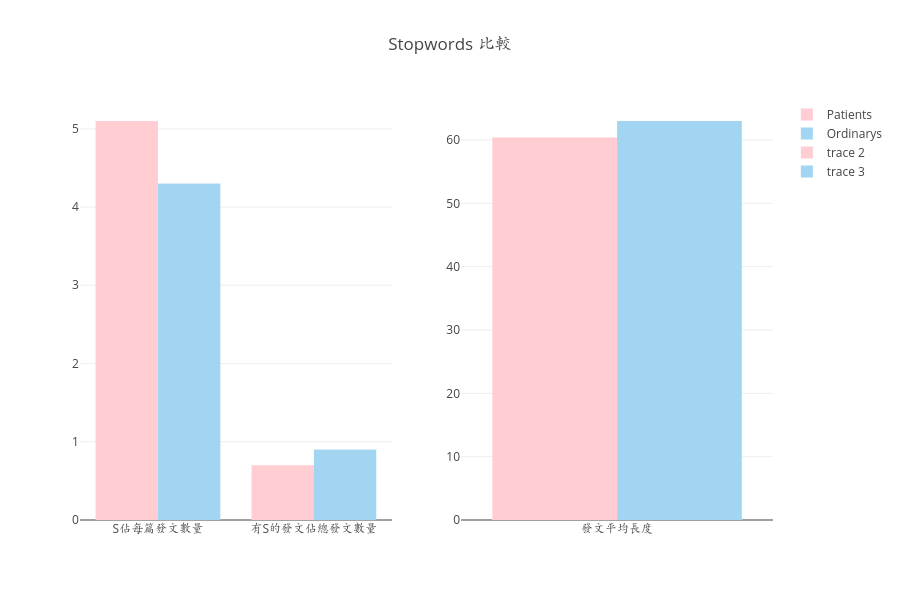

In [53]:
trace1_p = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                  y=[round(patients_total[0]/patients_total[1],1), round(patients_total[1]/patients_total[2],1)],
                  name='Patients',
                  marker=dict(color='#ffcdd2'))

trace1_o = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                y=[round(ordinarys_total[0]/ordinarys_total[1],1), round(ordinarys_total[1]/ordinarys_total[2],1)],
                name='Ordinarys',
                marker=dict(color='#A2D5F2'))

trace2_p = go.Bar(x=['發文平均長度'],
                y=[patients_total[3]],
                marker=dict(color='#ffcdd2'))

trace2_o = go.Bar(x=['發文平均長度'],
                y=[ordinarys_total[3]],
                marker=dict(color='#A2D5F2'))

fig = plotly.tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1_p,1,1)
fig.append_trace(trace1_o,1,1)
fig.append_trace(trace2_p,1,2)
fig.append_trace(trace2_o,1,2)
fig['layout'].update(height=600, width=900, title='Stopwords 比較')
# fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename='img/stopwords_compare.png')
display(Image(filename='img/stopwords_compare.png'))
# py.iplot(fig)

In [164]:
base_texts = []
group_texts = []

for key in ordinarys.keys():
    base_texts.append(filter_tweet('\n'.join(ordinarys[key].getText())))

for key in patients.keys():
    group_texts.append(filter_tweet('\n'.join(patients[key].getText())))

corpus = base_texts + group_texts

In [254]:
vectorizer = TfidfVectorizer(stop_words="english",ngram_range = (1,2), min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
Y = np.array([0] * len(base_texts) + [1]*len(group_texts), dtype=int)
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifier.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [255]:
feature_indicies = np.argsort(classifier.feature_importances_)
vector2word = vectorizer.get_feature_names()

In [256]:
top_words = []
for i in range(50):
    vector = feature_indicies[-i-1]
    word = vector2word[vector]
    top_words.append(word)

In [257]:
top_words

['diagnosed',
 'pic',
 'people',
 'depression',
 'scared',
 'fact',
 'right',
 'feeling',
 'love',
 'pic love',
 'throw',
 'came',
 'ass',
 'fucked',
 'problems',
 'confused',
 'stay',
 'pure',
 'make sure',
 'energy',
 'tho',
 'shit',
 'stop',
 'door',
 'hot',
 'sorry',
 'shitty',
 'ice',
 'lost',
 'thank',
 'watched',
 'honestly',
 'took',
 'll',
 'like just',
 '13',
 'words',
 'told',
 'protect',
 'boobs',
 'dude',
 'real',
 'currently',
 'mental',
 'wtf',
 'surprised',
 'laugh',
 'hours',
 'wasn',
 'bit']

In [174]:
from sklearn.cross_validation import StratifiedShuffleSplit

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [179]:
from random import randint

In [202]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))

In [249]:
precisions = []
for train_index, test_index in sss:
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier = classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test)
    precisions.append(score)

[0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0
 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0
 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0
 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [205]:
np.mean(precisions)

0.67000000000000004

In [220]:
from sklearn.tree import export_graphviz

In [263]:
vectorizer2 = TfidfVectorizer(stop_words="english",ngram_range = (1,2), min_df=1)
X2 = vectorizer2.fit_transform(group_texts+group_texts)
idf2 = vectorizer2.idf_
Y2 = np.array([0] * len(group_texts) + [1]*len(group_texts), dtype=int)
classifier2  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifier2.fit(X2,Y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [264]:
feature_indicies2 = np.argsort(classifier2.feature_importances_)
vector2word2 = vectorizer2.get_feature_names()

In [265]:
top_words2 = []
for i in range(50):
    vector2 = feature_indicies2[-i-1]
    word2 = vector2word2[vector2]
    top_words2.append(word2)

In [266]:
top_words2

['caught',
 'second',
 'feel bad',
 'af',
 'does',
 'thanks',
 'feel',
 'really good',
 'friends',
 'miss',
 'lied',
 'send',
 'new',
 'precious',
 'feels',
 'fellow',
 'year old',
 'truth',
 'born',
 'walk away',
 'hi',
 'sure',
 'stop',
 'song',
 'wonderful',
 'boo',
 'pants',
 'lover',
 'strike',
 'candidate',
 'right',
 'held',
 'sauce',
 'france',
 'gonna',
 'weight',
 'graduation',
 'depression',
 'away',
 'relate',
 'long',
 'love ve',
 'life got',
 'distract',
 'pic',
 '30am',
 'cooking',
 'thought thing',
 'register',
 'need']

In [270]:
sss = StratifiedShuffleSplit(Y2, 1, random_state=randint(0,65536))
precisions2 = []
for train_index, test_index in sss:
    
    X_train, X_test = X2[train_index], X2[test_index]
    Y_train, Y_test = Y2[train_index], Y2[test_index]
    classifier = classifier2.fit(X_train, Y_train)
    score = classifier2.score(X_test, Y_test)
    precisions2.append(score)

In [271]:
np.mean(precisions2)

0.052631578947368418